# Naive Bayes for Classification of DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the Project is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

</p>



## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.


### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>



In [0]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# from plotly import plotly
# import plotly.offline as offline
# import plotly.graph_objs as go
# offline.init_notebook_mode()
from collections import Counter

In [0]:
#getting the file from google drive (resources data)
import gdown

url = 'https://drive.google.com/uc?id=1OcMV5zjAJI7OvNxxN4Ant52BDF3jrZOZ'
output = 'resources.csv'
# https://drive.google.com/file/d/1OcMV5zjAJI7OvNxxN4Ant52BDF3jrZOZ/view?usp=sharing
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1OcMV5zjAJI7OvNxxN4Ant52BDF3jrZOZ
To: /content/resources.csv
127MB [00:00, 295MB/s]


'resources.csv'

In [0]:
#getting the data from google drive (test data)
import gdown

url = 'https://drive.google.com/uc?id=1JGtsNLea4Q2HZQIgBp3pRrOfRN80qIg0'
# https://drive.google.com/file/d/1JGtsNLea4Q2HZQIgBp3pRrOfRN80qIg0/view?usp=sharing
output = 'train_data.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1JGtsNLea4Q2HZQIgBp3pRrOfRN80qIg0
To: /content/train_data.csv
201MB [00:00, 246MB/s]


'train_data.csv'

In [0]:
ls

resources.csv  sample_data/  train_data.csv


In [0]:
Project_data = pd.read_csv("train_data.csv")
Resources_data = pd.read_csv("resources.csv")
print("Shape of Train data ",Project_data.shape)
print("Shape of Train data ",Resources_data.shape)
print("-"*100)
print("The attributes in Resources_data are as folows " , "  -> "*5,Resources_data.columns.values)
print("The attributes in Project_data are as folows " , "  ->  "*5,Project_data.columns.values)

Shape of Train data  (109248, 17)
Shape of Train data  (1541272, 4)
----------------------------------------------------------------------------------------------------
The attributes in Resources_data are as folows    ->   ->   ->   ->   ->  ['id' 'description' 'quantity' 'price']
The attributes in Project_data are as folows    ->    ->    ->    ->    ->   ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [0]:
# here the code is chainging the date and time format used in the data to a standard form  and replacing the data with the new format and 
# replacing the same coloum  refrence to same are given below 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html

Project_data["Date"] = pd.to_datetime(Project_data["project_submitted_datetime"])
Project_data.drop("project_submitted_datetime",axis=1,inplace = True )
Project_data.sort_values(by=["Date"],inplace=True)
Project_data.head(2)


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,Date
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,Grades PreK-2,Math & Science,"Applied Sciences, Health & Life Science",Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1,2016-04-27 00:27:36
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,Grades 3-5,Special Needs,Special Needs,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1,2016-04-27 00:31:25


In [0]:
# find out the NAN values in the dataframe and fill with null 
# https://stackoverflow.com/questions/29530232/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
Project_data["teacher_prefix"] = Project_data["teacher_prefix"].fillna("null")
print("The number of NAN values in teacher_prefix Column is " + str(Project_data["teacher_prefix"].isnull().sum()))

The number of NAN values in teacher_prefix Column is 0


## 1.1 ** Preprocessing of the Text **

In [0]:
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

catogories = list(Project_data['project_subject_categories'].values)
cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The','')
        j = j.replace(' ','')
        temp+=j.strip()+" "
        temp = temp.replace('&','_') 
    cat_list.append(temp.strip().lower())
    
Project_data['clean_categories'] = cat_list
Project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in Project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))
print("The Worlds in sorted_cat_dict",sorted_cat_dict)

The Worlds in sorted_cat_dict {'warmth': 1388, 'care_hunger': 1388, 'history_civics': 5914, 'music_arts': 10293, 'appliedlearning': 12135, 'specialneeds': 13642, 'health_sports': 14223, 'math_science': 41421, 'literacy_language': 52239}


In [0]:
catogories1 = list(Project_data['project_subject_subcategories'].values)
cat_list1 = []
for i in catogories1:
    temp1 = ""
    for j in i.split(','): 
        if 'The' in j.split():
            j=j.replace('The','')
        j = j.replace(' ','') 
        temp1+=j.strip()+" " 
        temp1 = temp1.replace('&','_') 
    cat_list1.append(temp1.strip().lower())
    
Project_data['clean_sub_categories'] = cat_list1
Project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

from collections import Counter
my_counter1 = Counter()
for word in Project_data['clean_sub_categories'].values:
    my_counter1.update(word.split())

cat_dict1 = dict(my_counter1)
sorted_cat_dict1 = dict(sorted(cat_dict1.items(), key=lambda kv: kv[1]))
print("The Worlds in sorted_cat_dict1",sorted_cat_dict1)
for i in sorted_cat_dict1:
  print(i,sorted_cat_dict1[i])

The Worlds in sorted_cat_dict1 {'economics': 269, 'communityservice': 441, 'financialliteracy': 568, 'parentinvolvement': 677, 'extracurricular': 810, 'civics_government': 815, 'foreignlanguages': 890, 'nutritioneducation': 1355, 'warmth': 1388, 'care_hunger': 1388, 'socialsciences': 1920, 'performingarts': 1961, 'charactereducation': 2065, 'teamsports': 2192, 'other': 2372, 'college_careerprep': 2568, 'music': 3145, 'history_geography': 3171, 'health_lifescience': 4235, 'earlydevelopment': 4254, 'esl': 4367, 'gym_fitness': 4509, 'environmentalscience': 5591, 'visualarts': 6278, 'health_wellness': 10234, 'appliedsciences': 10816, 'specialneeds': 13642, 'literature_writing': 22179, 'mathematics': 28074, 'literacy': 33700}
economics 269
communityservice 441
financialliteracy 568
parentinvolvement 677
extracurricular 810
civics_government 815
foreignlanguages 890
nutritioneducation 1355
warmth 1388
care_hunger 1388
socialsciences 1920
performingarts 1961
charactereducation 2065
teamsports

In [0]:
school_state = list(Project_data['school_state'].values)
school_state_list = []
for i in school_state:
    temp2 = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp2 +=j.strip()+" "
        temp2 = temp2.replace('&','_')
    school_state_list.append(temp2.strip().lower())

Project_data['School_state'] = school_state_list
Project_data.drop(['school_state'], axis=1, inplace=True)

my_counter3 = Counter()
for word in Project_data['School_state'].values:
    my_counter3.update(word.split())
    
school_state_dict = dict(my_counter3)
sorted_school_state_dict = dict(sorted(school_state_dict.items(), key=lambda kv: kv[1]))
print("The Values in sorted_school_state_dict : ", sorted_school_state_dict)



The Values in sorted_school_state_dict :  {'vt': 80, 'wy': 98, 'nd': 143, 'mt': 245, 'ri': 285, 'sd': 300, 'ne': 309, 'de': 343, 'ak': 345, 'nh': 348, 'wv': 503, 'me': 505, 'hi': 507, 'dc': 516, 'nm': 557, 'ks': 634, 'ia': 666, 'id': 693, 'ar': 1049, 'co': 1111, 'mn': 1208, 'or': 1242, 'ky': 1304, 'ms': 1323, 'nv': 1367, 'md': 1514, 'ct': 1663, 'tn': 1688, 'ut': 1731, 'al': 1762, 'wi': 1827, 'va': 2045, 'az': 2147, 'nj': 2237, 'ok': 2276, 'wa': 2334, 'ma': 2389, 'la': 2394, 'oh': 2467, 'mo': 2576, 'in': 2620, 'pa': 3109, 'mi': 3161, 'sc': 3936, 'ga': 3963, 'il': 4350, 'nc': 5091, 'fl': 6185, 'ny': 7318, 'tx': 7396, 'ca': 15388}


In [0]:
# merge two column text dataframe: 
Project_data["essay"] = Project_data["project_essay_1"].map(str) +\
                        Project_data["project_essay_2"].map(str) + \
                        Project_data["project_essay_3"].map(str) + \
                        Project_data["project_essay_4"].map(str)

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(Project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:01<00:00, 1788.74it/s]


In [0]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentence in tqdm(Project_data['project_title'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:02<00:00, 41717.06it/s]


In [0]:
Project_data["clean_titles"] = preprocessed_titles
Project_data.drop(["project_essay_1"],axis=1,inplace=True)
Project_data.drop(["project_essay_2"],axis=1,inplace=True)
Project_data.drop(["project_essay_3"],axis=1,inplace=True)
Project_data.drop(["project_essay_4"],axis=1,inplace=True)
Project_data.drop(["project_title"],axis=1,inplace=True)

Merging the dataframes that is Train_csv and Resources_csv 

In [0]:
print("Project_data Columns are - >>> " , Project_data.columns ,"Resources_data Columns  ", Resources_data.columns)

Project_data Columns are - >>>  Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix',
       'project_grade_category', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'Date', 'clean_categories', 'clean_sub_categories', 'School_state',
       'essay', 'clean_titles'],
      dtype='object') Resources_data Columns   Index(['id', 'description', 'quantity', 'price'], dtype='object')


In [0]:
Price_data = Resources_data.groupby("id").agg({"price": "sum" ,"quantity" : "sum"}).reset_index()
Price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [0]:
Project_data = pd.merge(Project_data,Price_data,on="id",how = "left")
print("The Number of NAN values in PRoject_data : ",Project_data.isnull().sum())

The Number of NAN values in PRoject_data :  Unnamed: 0                                      0
id                                              0
teacher_id                                      0
teacher_prefix                                  0
project_grade_category                          0
project_resource_summary                        0
teacher_number_of_previously_posted_projects    0
project_is_approved                             0
Date                                            0
clean_categories                                0
clean_sub_categories                            0
School_state                                    0
essay                                           0
clean_titles                                    0
price                                           0
quantity                                        0
dtype: int64


In [0]:
# Project_data = Project_data.head(50000)
Y = Project_data["project_is_approved"].values
X = Project_data.drop(["project_is_approved"],axis = 1)
print(X.columns)
print(Project_data.shape)

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix',
       'project_grade_category', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'Date',
       'clean_categories', 'clean_sub_categories', 'School_state', 'essay',
       'clean_titles', 'price', 'quantity'],
      dtype='object')
(109248, 16)


In [0]:
#Splitting the data into train and test data_set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, stratify= Project_data['project_is_approved'],random_state=0)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33, stratify=Y_train)

In [0]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

ros = RandomOverSampler(sampling_strategy='minority',random_state=42)
x_train, y_train = ros.fit_resample(X_train, Y_train)
print('Resampled dataset shape %s' % Counter(y_train))
print("Capitial" ,"X","represents the original train_data and lower case" ,"x", "represnts the ramdonly over-sampled data")

Resampled dataset shape Counter({1: 41615, 0: 41615})
Capitial X represents the original train_data and lower case x represnts the ramdonly over-sampled data


In [0]:
# here we have to convert x into a dataframe 
x_train = pd.DataFrame(x_train,columns = X.columns)
x_train.shape
# s= Project_data['project_is_approved'].value_counts()
# s


(83230, 15)

In [0]:
print("Shape of Train data ",x_train.shape, y_train.shape)
print("="*100)
print("Shape of Train CV  data ",X_cv.shape, Y_cv.shape)
print("="*100)
print("Shape of Test data ",X_test.shape, Y_test.shape)
print("="*100)

Shape of Train data  (83230, 15) (83230,)
Shape of Train CV  data  (24155, 15) (24155,)
Shape of Test data  (36052, 15) (36052,)


## 1.2 Vectorizing data 

```
# One-Hotencoding for the Catogorial Values
# Standazing the Numerical Data for sclaing them to equal sclae 
```



In [0]:
vectorizer1 = CountVectorizer()
vectorizer1.fit(x_train['clean_sub_categories']) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
x_train_clean_subcat_ohe = vectorizer1.transform(x_train['clean_sub_categories'])
X_cv_clean_subcat_ohe = vectorizer1.transform(X_cv['clean_sub_categories'])
X_test_clean_subcat_ohe = vectorizer1.transform(X_test['clean_sub_categories'])

print("After vectorizations of the clean_sub_categories , One-hot-encoding shape of the data is")
print("Shape of Train data ",x_train_clean_subcat_ohe.shape, y_train.shape)
print("Shape of Train CV  data ",X_cv_clean_subcat_ohe.shape, Y_cv.shape)
print("Shape of Test data " ,X_test_clean_subcat_ohe.shape, Y_test.shape)

After vectorizations of the clean_sub_categories , One-hot-encoding shape of the data is
Shape of Train data  (83230, 30) (83230,)
Shape of Train CV  data  (24155, 30) (24155,)
Shape of Test data  (36052, 30) (36052,)


In [0]:
vectorizer2 = CountVectorizer()
vectorizer2.fit(x_train['clean_categories']) # fit has to happen only on train data


# we use the fitted CountVectorizer to convert the text to vector
x_train_clean_categories_ohe = vectorizer2.transform(x_train['clean_categories'])
X_cv_clean_categories_ohe = vectorizer2.transform(X_cv['clean_categories'])
X_test_clean_categories_ohe = vectorizer2.transform(X_test['clean_categories'])

print("After vectorizations of the clean_categories, One-hot-encoding shape of the data is")
print("Shape of Train data ",x_train_clean_categories_ohe.shape, y_train.shape)
print("Shape of Train CV  data ",X_cv_clean_categories_ohe.shape, Y_cv.shape)
print("Shape of Test data " ,X_test_clean_categories_ohe.shape, Y_test.shape)

After vectorizations of the clean_categories, One-hot-encoding shape of the data is
Shape of Train data  (83230, 9) (83230,)
Shape of Train CV  data  (24155, 9) (24155,)
Shape of Test data  (36052, 9) (36052,)


In [0]:
vectorizer3 = CountVectorizer()
vectorizer3.fit(x_train['teacher_prefix'].values.astype('U')) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_teacher_ohe = vectorizer3.transform(x_train['teacher_prefix'].values.astype('U'))
X_cv_teacher_ohe = vectorizer3.transform(X_cv['teacher_prefix'].values.astype('U'))
X_test_teacher_ohe = vectorizer3.transform(X_test['teacher_prefix'].values.astype('U'))

print("After vectorizations of the teacher_prefix , One-hot-encoding shape of the data is")
print("Shape of Train data ",x_train_teacher_ohe.shape, y_train.shape)
print("Shape of Train CV  data ",X_cv_teacher_ohe.shape, Y_cv.shape)
print("Shape of Test data " ,X_test_teacher_ohe.shape, Y_test.shape)

After vectorizations of the teacher_prefix , One-hot-encoding shape of the data is
Shape of Train data  (83230, 6) (83230,)
Shape of Train CV  data  (24155, 6) (24155,)
Shape of Test data  (36052, 6) (36052,)


In [0]:
vectorizer4 = CountVectorizer()
vectorizer4.fit(x_train['School_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_state_ohe = vectorizer4.transform(x_train['School_state'].values)
X_cv_state_ohe = vectorizer4.transform(X_cv['School_state'].values)
X_test_state_ohe = vectorizer4.transform(X_test['School_state'].values)

print("After vectorizations of the School_state , One-hot-encoding shape of the data is")
print("Shape of Train data ",x_train_state_ohe.shape, y_train.shape)
print("Shape of Train CV  data ",X_cv_state_ohe.shape, Y_cv.shape)
print("Shape of Test data " ,X_test_state_ohe.shape, Y_test.shape)

After vectorizations of the School_state , One-hot-encoding shape of the data is
Shape of Train data  (83230, 51) (83230,)
Shape of Train CV  data  (24155, 51) (24155,)
Shape of Test data  (36052, 51) (36052,)


In [0]:
grade_cat_list = []
for grade in X_train['project_grade_category'].values:
  grade = grade.replace("-","_").lower()
  grade = grade.replace(" ","_").lower()
  grade_cat_list.append(grade)


X_train['clean_grade'] = grade_cat_list
X_train.drop(['project_grade_category'], axis=1, inplace=True)

my_counter = Counter()
for word in X_train['clean_grade'].values:
     my_counter.update(word.split())
project_grade_category_dict= dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))
print(sorted_project_grade_category_dict)

{'grades_9_12': 4928, 'grades_6_8': 7534, 'grades_3_5': 16645, 'grades_prek_2': 19934}


In [0]:
vectorizer5 = CountVectorizer(vocabulary=list(sorted_project_grade_category_dict.keys()), lowercase=False, binary=True)
vectorizer5.fit(x_train['project_grade_category'].values) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
x_train_grade_ohe = vectorizer5.transform(x_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer5.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer5.transform(X_test['project_grade_category'].values)

print("After vectorizations of the project_grade_category , One-hot-encoding shape of the data is")
print("Shape of Train data ",x_train_grade_ohe.shape, y_train.shape)
print("Shape of Train CV  data ",X_cv_grade_ohe.shape, Y_cv.shape)
print("Shape of Test data " ,X_test_grade_ohe.shape,Y_test.shape)

After vectorizations of the project_grade_category , One-hot-encoding shape of the data is
Shape of Train data  (83230, 4) (83230,)
Shape of Train CV  data  (24155, 4) (24155,)
Shape of Test data  (36052, 4) (36052,)


### Normalizing the numerical features: Price

In [0]:
from sklearn.preprocessing import Normalizer
standard_vector1 = Normalizer()
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshapstandard_vector2e(1, -1)  if it contains a single sample.
standard_vector1.fit(x_train['price'].values.reshape(-1,1))

x_train_price_std = standard_vector1.transform(x_train['price'].values.reshape(-1,1))
X_cv_price_std = standard_vector1.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_std = standard_vector1.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations of the price data ,  shape of the data after standazing")
print(x_train_price_std.shape, y_train.shape)
print(X_cv_price_std.shape, Y_cv.shape)
print(X_test_price_std.shape, Y_test.shape)

After vectorizations of the price data ,  shape of the data after standazing
(83230, 1) (83230,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [0]:
from sklearn.preprocessing import Normalizer
standard_vector2 = Normalizer()
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standard_vector2.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

x_train_projects_std = standard_vector2.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_projects_std = standard_vector2.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_projects_std = standard_vector2.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations of the teacher_number_of_previously_posted_projects , shape of the data after standazing")
print(x_train_projects_std.shape, y_train.shape)
print(X_cv_projects_std.shape,Y_cv.shape)
print(X_test_projects_std.shape, Y_test.shape)

After vectorizations of the teacher_number_of_previously_posted_projects , shape of the data after standazing
(83230, 1) (83230,)
(24155, 1) (24155,)
(36052, 1) (36052,)


In [0]:
from sklearn.preprocessing import Normalizer
standard_vector3 = Normalizer()
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standard_vector3.fit(x_train['quantity'].values.reshape(-1,1))

x_train_qty_std = standard_vector3.transform(x_train['quantity'].values.reshape(-1,1))
X_cv_qty_std = standard_vector3.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_qty_std = standard_vector3.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(x_train_qty_std.shape, y_train.shape)
print(X_cv_qty_std.shape, Y_cv.shape)
print(X_test_qty_std.shape, Y_test.shape)

After vectorizations
(83230, 1) (83230,)
(24155, 1) (24155,)
(36052, 1) (36052,)


## 2.1 Apply Multinomial NaiveBayes on these feature sets


```
Set 1: categorical, numerical features + project_title(BOW) + preprocessed_eassay (BOW)
Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF)

`**Difference between fit(),transform(),fit_transform()**`
To center the data (make it have zero mean and unit standard error), you subtract the mean and then divide the result by the
standard deviation.
fit() just calculates the parameters (e.g. mu and sigma in case of StandardScaler) and saves them as an internal objects state.
Afterwards, you can call its transform() method to apply the transformation to a particular set of examples
for egs fit() function happens only on training data while transform () involves changing the values by keeping mu and sigma in
calculation x'= ((x-mu)/sigma))
Using fix_transform(), we join these two steps and is used for the initial fitting of parameters on the training set x, but it also
returns a transformed x′. Internally, it just calls first fit() and then transform() on the same data.
generally fit_transform() should be applied on train data,and not on cv and test data,once fit has been done then we can use
transform () on cv and test data

```



## 2.1.1 Set : 1 Applying Naive Bayes on categorical, numerical features + project_title(BOW) + preprocessed_eassay (BOW)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer6 = CountVectorizer(min_df=5,tokenizer = lambda x: x.split(), max_features=20000,ngram_range=(1, 4))
vectorizer6.fit(x_train['essay'].values) # fit has to happen only on train data

# we use the transform Text_data to vector , BOW CountVectorizer
x_train_essay_bow = vectorizer6.transform(x_train['essay'].values) # this the vectorization of the oversampled data we do it as we dont want a baised model 
X_cv_essay_bow = vectorizer6.transform(X_cv['essay'].values)  # here we use the X_CV for vectorization( only x_train is oversampled)
X_test_essay_bow = vectorizer6.transform(X_test['essay'].values)

print("*"*100)
print("After vectorizations of the essay data the shape of the data is ")
print("Shape of the x_train data after Vectorization using BOW " , x_train_essay_bow.shape, y_train.shape)
print("Shape of the X_cv data after Vectorization using BOW " ,    X_cv_essay_bow.shape, Y_cv.shape)
print("Shape of the X_test_ data after Vectorization using BOW " ,    X_test_essay_bow.shape, Y_test.shape)

****************************************************************************************************
After vectorizations of the essay data the shape of the data is 
Shape of the x_train data after Vectorization using BOW  (83230, 20000) (83230,)
Shape of the X_cv data after Vectorization using BOW  (24155, 20000) (24155,)
Shape of the X_test_ data after Vectorization using BOW  (36052, 20000) (36052,)


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer7 = CountVectorizer(min_df=5,tokenizer = lambda x: x.split(), max_features=5000)
vectorizer7.fit(x_train['clean_titles'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_titles_bow = vectorizer7.transform(x_train['clean_titles'].values)
X_cv_titles_bow = vectorizer7.transform(X_cv['clean_titles'].values)
X_test_titles_bow = vectorizer7.transform(X_test['clean_titles'].values)

print("After vectorizations of the clean_titles(Project Titles) data the shape of the data is")
print("Shape of the x_train data after Vectorization using BOW " ,x_train_titles_bow.shape, y_train.shape)
print("Shape of the X_cv data after Vectorization using BOW " ,X_cv_titles_bow.shape, Y_cv.shape)
print("Shape of the X_test_ data after Vectorization using BOW " ,X_test_titles_bow.shape, Y_test.shape)

After vectorizations of the clean_titles(Project Titles) data the shape of the data is
Shape of the x_train data after Vectorization using BOW  (83230, 4803) (83230,)
Shape of the X_cv data after Vectorization using BOW  (24155, 4803) (24155,)
Shape of the X_test_ data after Vectorization using BOW  (36052, 4803) (36052,)


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer8 = CountVectorizer(min_df=5,tokenizer = lambda x: x.split(), max_features=10000,ngram_range=(1, 4))
vectorizer8.fit(x_train['project_resource_summary']) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_summary_bow = vectorizer8.transform(x_train['project_resource_summary'])
X_cv_summary_bow = vectorizer8.transform(X_cv['project_resource_summary'])
X_test_summary_bow = vectorizer8.transform(X_test['project_resource_summary'])

print("After vectorizations of the project_resource_summary data the shape of the data is")
print("Shape of the x_train data after Vectorization using BOW " ,x_train_summary_bow.shape, y_train.shape)
print("Shape of the X_cv data after Vectorization using BOW " ,X_cv_summary_bow.shape, Y_cv.shape)
print("Shape of the X_test_ data after Vectorization using BOW " ,X_test_summary_bow.shape, Y_test.shape)
print("*"*100)

After vectorizations of the project_resource_summary data the shape of the data is
Shape of the x_train data after Vectorization using BOW  (83230, 10000) (83230,)
Shape of the X_cv data after Vectorization using BOW  (24155, 10000) (24155,)
Shape of the X_test_ data after Vectorization using BOW  (36052, 10000) (36052,)
****************************************************************************************************


### Merging all the Vectorized data for making the Data matrix 

In [0]:
from scipy.sparse import hstack
X1_tr = hstack((x_train_clean_categories_ohe,x_train_clean_subcat_ohe,x_train_teacher_ohe,x_train_state_ohe,\
                x_train_grade_ohe,x_train_titles_bow,x_train_essay_bow,x_train_price_std,x_train_projects_std,x_train_qty_std)).tocsr()
X1_cv = hstack((X_cv_clean_categories_ohe,X_cv_clean_subcat_ohe,X_cv_teacher_ohe,X_cv_state_ohe,X_cv_grade_ohe,\
                X_cv_price_std,X_cv_projects_std,X_cv_qty_std,X_cv_essay_bow,X_cv_titles_bow)).tocsr()
X1_te =hstack((X_test_clean_categories_ohe,X_test_clean_subcat_ohe,X_test_teacher_ohe,X_test_state_ohe,\
               X_test_grade_ohe,X_test_essay_bow,X_test_titles_bow,X_test_price_std,X_test_projects_std,X_test_qty_std)).tocsr()


print("The final Data Matrix for Set:1" , " All the shapes of the data represent the merged features as mentioned in the tittle")
print("shape of X_train is : ",            X1_tr.shape)
print("shape of X_Cross validation is :" , X1_cv.shape)
print("shape of X_test is ",               X1_te.shape)

The final Data Matrix for Set:1  All the shapes of the data represent the merged features as mentioned in the tittle
shape of X_train is :  (83230, 24906)
shape of X_Cross validation is : (24155, 24906)
shape of X_test is  (36052, 24906)


100%|██████████| 9/9 [00:03<00:00,  2.64it/s]


Ploting the Log values of alpha as it would exactly plot the values of the point's considered 


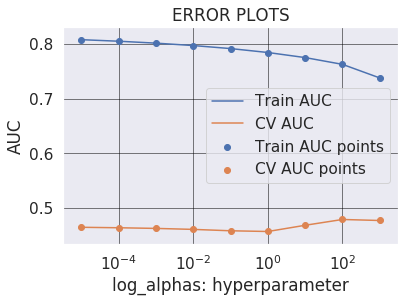

In [0]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math

train_auc = []
cv_auc = [] 
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,  100,  1000] 
for i in tqdm(alpha):
    neigh = MultinomialNB(alpha=i,class_prior=[0.5,0.5])
    neigh.fit(X1_tr, y_train)

    y_train_pred = neigh.predict_proba(X1_tr)[:,1]    
    y_cv_pred = neigh.predict_proba(X1_cv)[:,1]

    # roc_auc_score(y_tr, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, y_cv_pred))
  
plt.semilogx(alpha, train_auc, label='Train AUC')
plt.semilogx(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
print("Ploting the Log values of alpha as it would exactly plot the values of the point's considered ")
plt.legend()
plt.xlabel("log_alphas: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [0]:
alpha1= 100
print("The Error Plot above shows the best Aplha value as :" , alpha )

The Error Plot above shows the best Aplha value as : [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]


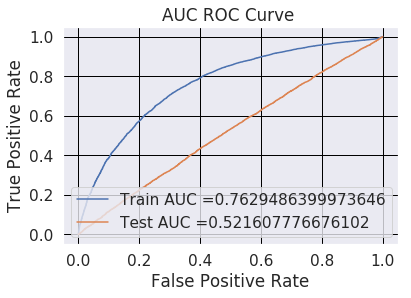

In [0]:
from sklearn.metrics import roc_curve, auc
neigh = MultinomialNB(alpha=alpha1,class_prior=[0.5,0.5])
neigh.fit(X1_tr, y_train)
y_train_pred = neigh.predict_proba(X1_tr)[:,1]     
y_test_pred = neigh.predict_proba(X1_te)[:,1] 
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC ROC Curve ")
plt.grid(color='black', linestyle='-', linewidth=1)
plt.show()

In [0]:
#this is the custom function for predecting the best thershold and sorting the values according the threshould 
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),3), "for threshold", np.round(t,3))
    return t

In [0]:
# we only set the threshould by using the train data and the test data is not altered at any time , as it could cause the data leakeage problem 
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
# print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("tn, fp, fn, tp", "=", confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)).ravel())
print("Test confusion matrix")
# print(confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t)))
print("tn, fp, fn, tp", "=", confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t)).ravel())
print("here the threshold is ", np.round(best_t,3) , "i can change the threshold values according to Requirement in the confusion meterix")

the maximum value of tpr*(1-fpr) 0.509 for threshold 0.449
Train confusion matrix
tn, fp, fn, tp = [28699 12916 10880 30735]
Test confusion matrix
tn, fp, fn, tp = [ 2504  2955 13505 17088]
here the threshold is  0.449 i can change the threshold values according to Requirement in the confusion meterix


In [0]:
Confusion_metrix_Train_data = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
Confusion_metrix_Test_data = pd.DataFrame(confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t)))


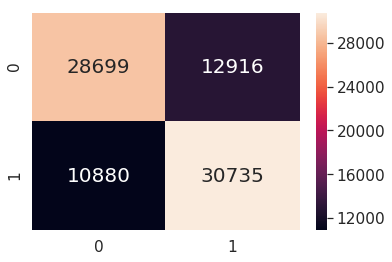

In [0]:
import seaborn as sns
sns.set(font_scale=1.4)#for label size
sns.heatmap(Confusion_metrix_Train_data,annot=True, annot_kws={"size": 20},fmt ="g")

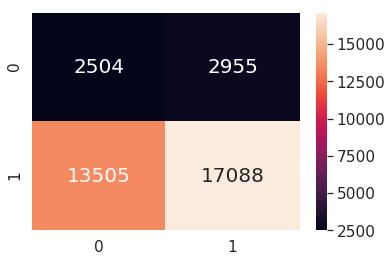

In [0]:
sns.heatmap(Confusion_metrix_Test_data,annot=True, annot_kws={"size": 20},fmt ="g")

## Conclusion for set 1: 


1.   The BOW for set 1 , gives us the results with a very low accuracy the AUC score was found out to be 50 which resembles that it is a random model and will give random results when tested  
2.   The Confusion matrix gives us the TRP and FPR and it has been set with thershold of 0.509 , as I wanted to maximise the TPR with the help of setting the thershold . 
3.   The model of BOW is not performing as expected beacuse it doesnt consider the least occuring words to be important it just creates a orthogonal vector of the words which are present and dones not preserver the schematic meaning of the words too . 

Area's of improvemnt's

1. The areas of imporvement are we can use Unigrams or "n -grams " this can imporove the models performance .



## 2.1.2 Set : 2 Categorical, Numerical features + Poject_title(TFIDF)+ Peprocessed_eassay (TFIDF)

In [0]:
# Applying TF-IDF on Prohect title :
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer9 = TfidfVectorizer(min_df=10)
vectorizer9.fit(x_train["clean_titles"].values)

x_tain_project_titles_tfidf = vectorizer9.transform(x_train["clean_titles"].values)
X_cv_project_titles_tfidf = vectorizer9.transform(X_cv["clean_titles"].values)
X_test_project_titles_tfidf = vectorizer9.transform(X_test["clean_titles"].values)


print("After TFIDF vectorizations of the clean_titles , shape of the data after standazing")
print(x_tain_project_titles_tfidf.shape, y_train.shape)
print(X_cv_project_titles_tfidf.shape,Y_cv.shape)
print(X_test_project_titles_tfidf.shape, Y_test.shape)
print("*"*100)

After TFIDF vectorizations of the clean_titles , shape of the data after standazing
(83230, 3017) (83230,)
(24155, 3017) (24155,)
(36052, 3017) (36052,)
****************************************************************************************************


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer10 = TfidfVectorizer(min_df=10)
vectorizer10.fit(x_train["essay"])

x_tain_essay_tfidf = vectorizer10.transform(x_train["essay"].values)
X_cv_essay_tfidf = vectorizer10.transform(X_cv["essay"].values)
X_test_essay_tfidf = vectorizer10.transform(X_test["essay"].values)
 

print("After TFIDF vectorizations of the essay , shape of the data after standazing")
print(x_tain_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape,Y_cv.shape)
print(X_test_essay_tfidf.shape, Y_test.shape)
print("*"*100)

After TFIDF vectorizations of the essay , shape of the data after standazing
(83230, 15872) (83230,)
(24155, 15872) (24155,)
(36052, 15872) (36052,)
****************************************************************************************************


In [0]:
from scipy.sparse import hstack
X2_tr = hstack((x_train_clean_categories_ohe,x_train_clean_subcat_ohe,x_train_teacher_ohe,x_train_state_ohe,\
                x_train_grade_ohe,x_train_price_std,x_train_projects_std,x_train_qty_std,x_tain_project_titles_tfidf,x_tain_essay_tfidf)).tocsr()
X2_cv = hstack((X_cv_clean_categories_ohe,X_cv_clean_subcat_ohe,X_cv_teacher_ohe,X_cv_state_ohe,X_cv_grade_ohe,\
                X_cv_price_std,X_cv_projects_std,X_cv_qty_std,X_cv_project_titles_tfidf,X_cv_essay_tfidf)).tocsr()
X2_te =hstack((X_test_clean_categories_ohe,X_test_clean_subcat_ohe,X_test_teacher_ohe,X_test_state_ohe,\
               X_test_grade_ohe,X_test_price_std,X_test_projects_std,X_test_qty_std,X_test_project_titles_tfidf,X_test_essay_tfidf)).tocsr()


print("The final Data Matrix for Set:2" , " All the shapes of the data represent the merged features as mentioned in the tittle")
print("shape of X_train is : ",            X2_tr.shape)
print("shape of X_Cross validation is :" , X2_cv.shape)
print("shape of X_test is ",               X2_te.shape)

The final Data Matrix for Set:2  All the shapes of the data represent the merged features as mentioned in the tittle
shape of X_train is :  (83230, 18992)
shape of X_Cross validation is : (24155, 18992)
shape of X_test is  (36052, 18992)


100%|██████████| 9/9 [00:01<00:00,  4.66it/s]


Ploting the Log values of alpha as it would exactly plot the values of the point's considered 


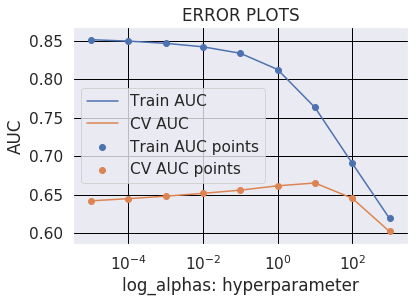

In [0]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math

train_auc1 = []
cv_auc1 = [] 
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,  100,  1000] 
for i in tqdm(alpha):
    neigh = MultinomialNB(alpha=i,class_prior=[0.5,0.5])
    neigh.fit(X2_tr, y_train)

      y_train_pred = neigh.predict_proba(X2_tr)[:,1]    
    y_cv_pred = neigh.predict_proba(X2_cv)[:,1]

    # roc_auc_score(y_tr, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc1.append(roc_auc_score(y_train,y_train_pred))
    cv_auc1.append(roc_auc_score(Y_cv, y_cv_pred))
  
plt.semilogx(alpha, train_auc1, label='Train AUC')
plt.semilogx(alpha, cv_auc1, label='CV AUC')

plt.scatter(alpha, train_auc1, label='Train AUC points')
plt.scatter(alpha, cv_auc1, label='CV AUC points')
print("Ploting the Log values of alpha as it would exactly plot the values of the point's considered ")
plt.legend()
plt.xlabel("log_alphas: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid(color='black', linestyle='-', linewidth=1)
plt.show()

In [0]:
alpha= 10
print("The Error Plot above shows the best Aplha value as :" , alpha )

The Error Plot above shows the best Aplha value as : 10


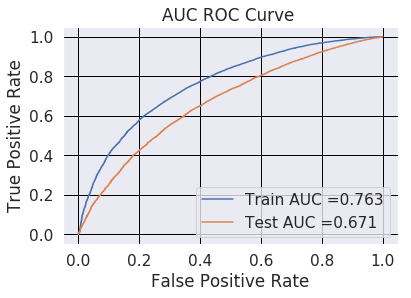

In [0]:
from sklearn.metrics import roc_curve, auc
neigh = MultinomialNB(alpha=alpha,class_prior=[0.5,0.5])
neigh.fit(X2_tr, y_train)
y_train_pred1 = neigh.predict_proba(neigh, X2_tr)    
y_test_pred1 = neigh.predict_proba(neigh, X2_te)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred1)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred1)
plt.plot(train_fpr, train_tpr, label="Train AUC ="+ str(np.round(auc(train_fpr, train_tpr),3)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(np.round(auc(test_fpr, test_tpr),3)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC ROC Curve ")
plt.grid(color='black', linestyle='-', linewidth=1)
plt.show()

In [0]:
#this is the custom function for predecting the best thershold and sorting the values according the threshould 
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", np.round(max(tpr*(1-fpr)),3), "for threshold", np.round(t,3))
    return t

In [0]:
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
# print(confusion_matrix(y_train, predict_with_best_t(y_train_pred1, best_t)))
print("tn, fp, fn, tp", "=", confusion_matrix(y_train, predict_with_best_t(y_train_pred1, best_t)).ravel())
print("Test confusion matrix")
# print(confusion_matrix(Y_test, predict_with_best_t(y_test_pred1, best_t)))
print("tn, fp, fn, tp", "=", confusion_matrix(Y_test, predict_with_best_t(y_test_pred1, best_t)).ravel())
print("here the threshold is ", np.round(best_t,3) , "i can change the threshold values according to Requirement in the confusion meterix")

the maximum value of tpr*(1-fpr) 0.482 for threshold 0.516
Train confusion matrix
tn, fp, fn, tp = [29900 11715 13688 27927]
Test confusion matrix
tn, fp, fn, tp = [ 3284  2175 10735 19858]
here the threshold is  0.516 i can change the threshold values according to Requirement in the confusion meterix


Confusion metrix for Train data 


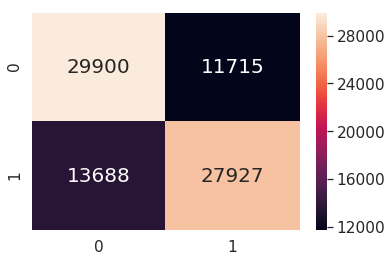

In [0]:
Confusion_metrix_Train_data = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred1, best_t)))
Confusion_metrix_Test_data = pd.DataFrame(confusion_matrix(Y_test, predict_with_best_t(y_test_pred1, best_t)))
import seaborn as sns
sns.set(font_scale=1.4)#for label size
print("Confusion metrix for Train data ")
sns.heatmap(Confusion_metrix_Train_data,annot=True, annot_kws={"size": 20},fmt ="g")

Confusion metrix for Test data


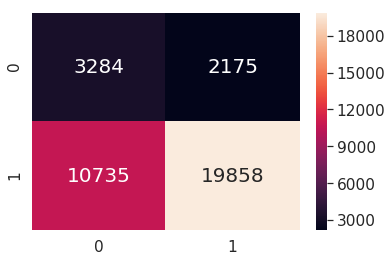

In [0]:
print("Confusion metrix for Test data")
sns.heatmap(Confusion_metrix_Test_data,annot=True, annot_kws={"size": 20},fmt ="g")



```
## Conclusion for set 2:

```


1.   TFIDF vectorizer gives very good results as compared to BOW as it equally considers the occurance of words in the Document Corpus
2.   The AUC was found arounf 70 % and hance could be increased by using N-grams. 
3.   The confusion matrix was formed using the thershould of 0.49 for maximising the TPR.






### 3.1 Top 10 features of "positive class" and top 10 features of "negative class" for feature matrix Set 1

In [0]:
# Feature set Consitis of all the Catogorial and Numerical features of BOW vectorization 

X1_tr = hstack((x_train_clean_categories_ohe,x_train_clean_subcat_ohe,x_train_teacher_ohe,x_train_state_ohe,\
                x_train_grade_ohe,x_train_titles_bow,x_train_essay_bow,x_train_price_std,x_train_projects_std,x_train_qty_std)).tocsr()
X1_cv = hstack((X_cv_clean_categories_ohe,X_cv_clean_subcat_ohe,X_cv_teacher_ohe,X_cv_state_ohe,X_cv_grade_ohe,\
                X_cv_price_std,X_cv_projects_std,X_cv_qty_std,X_cv_essay_bow,X_cv_titles_bow)).tocsr()
X1_te =hstack((X_test_clean_categories_ohe,X_test_clean_subcat_ohe,X_test_teacher_ohe,X_test_state_ohe,\
               X_test_grade_ohe,X_test_essay_bow,X_test_titles_bow,X_test_price_std,X_test_projects_std,X_test_qty_std)).tocsr()


print("The final Data Matrix for Set:1" , " All the shapes of the data represent the merged features as mentioned in the tittle")
print("shape of X_train is : ",            X1_tr.shape)
print("shape of X_Cross validation is :" , X1_cv.shape)
print("shape of X_test is ",               X1_te.shape)

The final Data Matrix for Set:1  All the shapes of the data represent the merged features as mentioned in the tittle
shape of X_train is :  (83230, 24906)
shape of X_Cross validation is : (24155, 24906)
shape of X_test is  (36052, 24906)


In [0]:
nb_bow = MultinomialNB(alpha =alpha1 ,class_prior=[0.5,0.5])
nb_bow.fit(X1_tr, y_train)

MultinomialNB(alpha=100, class_prior=[0.5, 0.5], fit_prior=True)

In [0]:
neg_class_prob_sorted = nb_bow.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb_bow.feature_log_prob_[1, :].argsort()

In [0]:
# https://stackoverflow.com/questions/14131615/possible-to-append-multiple-lists-at-once-python
from itertools import chain
Stacked_Feature_list = list(chain(vectorizer1.get_feature_names(),vectorizer2.get_feature_names(),vectorizer3.get_feature_names(),\
                                  vectorizer4.get_feature_names(),vectorizer5.get_feature_names(),vectorizer6.get_feature_names(),\
                                  vectorizer7.get_feature_names(),vectorizer8.get_feature_names(),x_train_qty_std,x_train_projects_std,x_train_price_std))



In [0]:
print("The words with higest importance in Postive class is")
print(np.take(Stacked_Feature_list, neg_class_prob_sorted[-30:-1]))
print("*"*20)
print("The words with higest importance in Negative class is")
print(np.take(Stacked_Feature_list, pos_class_prob_sorted[-30:-1]))

The words with higest importance in Postive class is
['my class and' 'fruits and vegetables' 'our school are' 'you in advance'
 'group of students who' 'students enter' 'enjoy' 'own' 'meaning'
 'will inspire' 'explore their' 'their communities' 'small'
 'school to learn' 'students will feel' 'middle class' 'of skills'
 'learners have' 'together they' 'radical' 'while having'
 'with your help we' 'donating to our project' 'school and my'
 'need to become' 'starting to' 'time or' 'up in the' 'comes']
********************
The words with higest importance in Negative class is
['on regular basis' 'our school are' 'fruits and vegetables'
 'you in advance' 'group of students who' 'students enter' 'enjoy' 'own'
 'will inspire' 'meaning' 'explore their' 'their communities' 'small'
 'of skills' 'middle class' 'together they' 'school to learn'
 'students will feel' 'learners have' 'radical' 'while having'
 'with your help we' 'donating to our project' 'school and my'
 'need to become' 'starting t

### 3.2 Top 10 features of "positive class" and top 10 features of "negative class" for feature matrix Set 2

In [0]:
from scipy.sparse import hstack
X2_tr = hstack((x_train_clean_categories_ohe,x_train_clean_subcat_ohe,x_train_teacher_ohe,x_train_state_ohe,\
                x_train_grade_ohe,x_train_price_std,x_train_projects_std,x_train_qty_std,x_tain_project_titles_tfidf,x_tain_essay_tfidf)).tocsr()
X2_cv = hstack((X_cv_clean_categories_ohe,X_cv_clean_subcat_ohe,X_cv_teacher_ohe,X_cv_state_ohe,X_cv_grade_ohe,\
                X_cv_price_std,X_cv_projects_std,X_cv_qty_std,X_cv_project_titles_tfidf,X_cv_essay_tfidf)).tocsr()
X2_te =hstack((X_test_clean_categories_ohe,X_test_clean_subcat_ohe,X_test_teacher_ohe,X_test_state_ohe,\
               X_test_grade_ohe,X_test_price_std,X_test_projects_std,X_test_qty_std,X_test_project_titles_tfidf,X_test_essay_tfidf)).tocsr()


print("The final Data Matrix for Set:2" , " All the shapes of the data represent the merged features as mentioned in the tittle")
print("shape of X_train is : ",            X2_tr.shape)
print("shape of X_Cross validation is :" , X2_cv.shape)
print("shape of X_test is ",               X2_te.shape)

The final Data Matrix for Set:2  All the shapes of the data represent the merged features as mentioned in the tittle
shape of X_train is :  (83230, 18992)
shape of X_Cross validation is : (24155, 18992)
shape of X_test is  (36052, 18992)


In [0]:
nb_bow2 = MultinomialNB(alpha=alpha ,class_prior=[0.5,0.5])
nb_bow2.fit(X2_tr, y_train)

MultinomialNB(alpha=0.01, class_prior=[0.5, 0.5], fit_prior=True)

In [0]:
neg_class_prob_sorted_set2 = nb_bow2.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted_set2 = nb_bow2.feature_log_prob_[1, :].argsort()

In [0]:
# https://stackoverflow.com/questions/14131615/possible-to-append-multiple-lists-at-once-python
from itertools import chain
Stacked_Feature_list1 = list(chain(vectorizer1.get_feature_names(),vectorizer2.get_feature_names(),vectorizer3.get_feature_names(),\
                                  vectorizer4.get_feature_names(),vectorizer5.get_feature_names(),vectorizer9.get_feature_names(),\
                                  vectorizer10.get_feature_names(),x_train_qty_std,x_train_projects_std,x_train_price_std))



In [0]:
# thers a import point to note that is if we take argsort then it gives values in ascending order so we have to select fetures form the last
print("The words with higest importance in Postive class is")
# i took features from -30 to -1 which means select all the features which are most important form the accendingly sorted array 
print(np.take(Stacked_Feature_list1, neg_class_prob_sorted[-30:-1]))
print("*"*20)
print("The words with higest importance in Negative class is")
print(np.take(Stacked_Feature_list1, pos_class_prob_sorted[-30:-1]))

The words with higest importance in Postive class is
['influence' 'cooler' 'mixing' array([1.]) 'dealing' 'provoking' 'cameras'
 'movable' array([1.]) array([1.]) 'children' 'slime' array([1.]) 'oxygen'
 'receivership' 'identical' 'looming' 'furthers' 'utilized' array([1.])
 array([1.]) array([1.]) 'blog' 'organization' 'jamestown' 'poured'
 'taylor' 'vitamin' 'ankle']
********************
The words with higest importance in Negative class is
['march' 'mixing' 'cooler' array([1.]) 'dealing' 'provoking' 'cameras'
 'movable' array([1.]) array([1.]) 'children' 'slime' array([1.])
 'looming' 'identical' 'utilized' 'oxygen' 'receivership' 'furthers'
 array([1.]) array([1.]) array([1.]) 'blog' 'organization' 'jamestown'
 'poured' 'taylor' 'vitamin' 'ankle']


## Conclusion 

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Alpha:Hyper Parameter", " Test AUC"]
x.add_row(["BOW", "Multinomial Naive Bayes", 0.01, 0.55])
x.add_row(["TFIDF", "Multinomial Naive Bayes", 0.01, 0.68])
print(x)

+------------+-------------------------+-----------------------+-----------+
| Vectorizer |          Model          | Alpha:Hyper Parameter |  Test AUC |
+------------+-------------------------+-----------------------+-----------+
|    BOW     | Multinomial Naive Bayes |          0.01         |    0.55   |
|   TFIDF    | Multinomial Naive Bayes |          0.01         |    0.68   |
+------------+-------------------------+-----------------------+-----------+
